# 4サイトHubbard模型の厳密対角化
このノートでは、4サイト1次元ハバード(Hubbard)模型を対角化し、厳密な基底状態と基底エネルギーを求めます。言語はJulia 1.1です。

## モデル
1次元ハバード(Hubbard)模型:

$$
H = -t \sum_{i} \sum_{\sigma} (c_{i \sigma}^{\dagger} c_{i+1 \sigma}+ c_{i+1 \sigma}^{\dagger} c_{i \sigma}) - \mu \sum_i \sum_{\sigma} c_{i \sigma}^{\dagger} c_{j \sigma} + U \sum_i n_{i \uparrow} n_{i \downarrow}
$$
を考えます。
ここで、$c_{i \sigma}$は、サイト$i$、スピン$\sigma$のフェルミオンの消滅演算子です。また、$n_{i \sigma} = c_{i \sigma}^{\dagger} c_{i \sigma}$です。
格子の数は4とし、周期的境界条件が課されているとします。

## ヒルベルト空間
格子の一つ一つにはアップスピンの電子かダウンスピンの電子が入ります。
ですので、一つのサイトでは、

$$
|0\rangle \\
c_{\uparrow}^{\dagger} |0\rangle = |\uparrow \rangle \\
c_{\downarrow}^{\dagger} |0\rangle = |\downarrow \rangle \\
c_{\uparrow}^{\dagger} c_{\downarrow}^{\dagger}  |0\rangle = |\uparrow \downarrow \rangle 
$$

の4つの状態があります。つまり、$N$サイトある場合には、$4^N$個の状態が存在します。今、$N=4$を考えているので、状態は全部で$4^4 = 256$通りです。
この状態を表現するために、以下のようにしてみましょう：

$$
c_{1 \uparrow}^{\dagger} |0\rangle = |0000;0001 \rangle  \\
c_{2 \downarrow}^{\dagger}   c_{2 \uparrow}^{\dagger} |0\rangle = |0010;0010 \rangle \\
 c_{2 \downarrow}^{\dagger} c_{2 \uparrow}^{\dagger} c_{1 \uparrow}^{\dagger}  |0\rangle = |0010;0011 \rangle  \\
$$

ここで、$|0010;0011 \rangle $は、アップスピンがサイト2とサイト1に、ダウンスピンがサイト1に入っていることを意味します。サイトに電子がいるかいないかを0と1で表し、右側の四つがアップスピン、左側の四つをダウンスピンの位置としました。右端をサイト1、左端をサイト4とします。
さらに、この８つの0と1の集まりを二進法と見なせば、状態にラベルをつけることができます。例えば、$|0000;0001 \rangle $は$00000001=1$、
$|0010;0011 \rangle $は$00100011 = 35$となります。状態は全部0から全部1まであるので、状態の番号は0から255までになります。

## 生成消滅演算子
上で定義したある状態に対して生成消滅演算子を作用させると、別の状態に変化します。例えば、

$$
c_{1 \uparrow} |0000;0001 \rangle =c_{1 \uparrow}  c_{1 \uparrow}^{\dagger} |0\rangle =  |0000;0000 \rangle \\
c_{2 \uparrow}^{\dagger} |0000;0001 \rangle = c_{2 \uparrow}^{\dagger}  c_{1 \uparrow}^{\dagger} |0\rangle = |0011;0000 \rangle
$$
となります。ここで、フェルミオンの生成消滅演算子には反交換関係:

$$
c_{i \sigma}^{\dagger} c_{j \sigma'} + c_{j \sigma'} c_{i \sigma}^{\dagger} = \delta_{ij} \delta_{\sigma} \\
c_{i \sigma}^{\dagger} c_{j \sigma'}^{\dagger} + c_{j \sigma'}^{\dagger}  c_{i \sigma}^{\dagger} = 0 \\
c_{i \sigma} c_{j \sigma'}+ c_{j \sigma'} c_{i \sigma} = 0 
$$
があることと、真空状態に消滅演算子を作用させると消える$c_{i \sigma} |0 \rangle = 0$ことを使いました。
整理する際には、反交換関係を使い右端に消滅演算子を寄せて消すことを繰り返します。また、生成演算子の順番は、右から左に1から4が並ぶようにします。アップスピンは右側、ダウンスピンは左側です。
例えば、

$$
c_{1 \downarrow}^{\dagger} |0010;0010 \rangle = c_{1 \downarrow}^{\dagger}  c_{2 \downarrow}^{\dagger}   c_{2 \uparrow}^{\dagger} |0\rangle = -c_{2 \downarrow}^{\dagger}   c_{1 \downarrow}^{\dagger} c_{2 \uparrow}^{\dagger} |0\rangle =  -|0011;0010 \rangle
$$
となります。ここで、マイナスの符号が出る場合があることに気をつけてください。
このマイナス符号は、作用させる前の状態と作用させた後の状態を比較し、変化させた部分の左側に何個1があるかを見ればわかります。
つまり、上の例であれば、左から4番目が0から1に変化していますが、左から3番目に1が1個あるため、符号は$(-1)^{1} = -1$となります。

状態の数は全部で256個ありますので、一つの演算子を256x256の行列として表現できれば、それらの演算子の組でハミルトニアンを表現することができます。ハミルトニアンは粒子数が保存するので、自分の考えたい粒子数を持つ状態だけを持ってくれば、もう少し状態の数を減らすことができます。
しかしながら、今回はたったの4サイトなので、256x256の行列をそのまま作ることにします。


## 状態の表現
次に、上で述べた状態をプログラム上で表現します。今回は4サイトだけなので、256個の状態を全て扱うことにします。
まず、状態の番号を入れるとどのサイトに電子がいるかを調べる関数を作ります。二進法の表現は、0と1だけがあればいいので、要素がBoolの配列を使います。Boolの値はtrueかfalseですが、これは1と0としてみなすことができます。そこで、これを使います。
また、状態をプリントするための関数として、display関数を定義します。display関数はBaseに入っているので、Array{Bool,1}の型が来た時だけ状態をプリントするように多重ディスパッチを使います。


In [1]:
function i2sites(i,nsite)
    n = 2*nsite
    sites = zeros(Bool,n)
    ii = i
    for i=1:n
        sites[i] = ii % 2
        ii = div(ii-sites[i],2)
    end
    
    return sites
end

function Base.display(sites::Array{Bool,1})
    n = length(sites)
    print("|")
    for i=n:-1:1
        if i == div(n,2)
            print(";")
        end
        if sites[i]
            print("1")
        else
            print("0")
        end

    end
    println(">")
end

i = 4
println(i)
nsite = 4
a = i2sites(i,nsite)
display(a)



4
|0000;0100>


次に、どのサイトがどの状態の番号なのかを調べる関数を定義します。

In [2]:
function sites2i(sites)
    n = length(sites)
    ii = 0
    for i=1:n
        ii += sites[i]*2^(i-1)
    end
    return ii
end

i = 4
println(i)
nsite = 4
a = i2sites(i,nsite)
display(sites2i(a))

4

4


サイトに電子がいるかどうかの関数を作ります。

In [3]:
function check_site(isite,sites)
    return sites[isite]
end
    
i = 255
println(i)
nsite = 4
sites = i2sites(i,nsite)
display(sites)
isite = 1
println(check_site(isite,sites))

255
|1111;1111>
true


そして、考えているサイトよりも左側の粒子の数を数える関数を作ります。

In [4]:
function check_sign(isite,sites)
    n = length(sites)
    sign = 1
    for jsite = n:-1:isite+1
        if sites[jsite]
            sign *= -1
        end
    end
    return sign
end
    
i = 255
println(i)
nsite = 4
sites = i2sites(i,nsite)
display(sites)
isite = 1
println(check_sign(isite,sites))

255
|1111;1111>
-1


ここまでできれば、あとはあるサイトでの消滅演算子を行列として作るだけです。

In [13]:
function make_c(ith,ispin,nsite)
    isite = (ispin-1)*nsite +ith
    ndim = 4^nsite
    mat_c = zeros(Int,ndim,ndim)
    
    for j=1:ndim
        sites = i2sites(j,nsite)
        if check_site(isite,sites)
            sign = check_sign(isite,sites)
            sites[isite] = false
            i = sites2i(sites)
            mat_c[i+1,j+1] = sign
        end        
    end
    return mat_c
end




function make_cs(nsite)
    vec_c = []
    vec_cdag = []
    for ispin = 1:2
        for ith=1:nsite        
            mat_c = make_c(ith,ispin,nsite)
            push!(vec_c,mat_c)
            push!(vec_cdag,mat_c')
        end
    end
    
    return vec_c,vec_cdag
end

nsite = 2
vec_c,vec_cdag = make_cs(nsite)
#vec_cdag[3]*vec_c[3]*vec_cdag[3+4]*vec_c[4+3]


(Any[[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 -1; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]], Any[[0 0 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 0; 0 0 … -1 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]])

そして、ハミルトニアンを、作った生成消滅演算子を組み合わせて作ります。

In [52]:
function make_hamiltonian(μ,U,nsite)
    ndim = 4^nsite
    hamiltonian = zeros(Float64,ndim,ndim)
    vec_c,vec_cdag = make_cs(nsite)
    for i=1:nsite
        j = i+1
        j += ifelse(j > nsite,-nsite,0)
        
        if 1 <= j <= nsite
        for ispin=1:2
            ii = (ispin-1)*nsite + i
            jj = (ispin-1)*nsite + j
            hamiltonian += - vec_cdag[ii]*vec_c[jj]
        end
        end
        
        j = i-1
        j += ifelse(j < 1,nsite,0)
        if 1 <= j <= nsite
        for ispin=1:2
            ii = (ispin-1)*nsite + i
            jj = (ispin-1)*nsite + j
            hamiltonian += - vec_cdag[ii]*vec_c[jj]
        end
        end

        
        j = i
        for ispin=1:2
            ii = (ispin-1)*nsite + i
            jj = (ispin-1)*nsite + j
            hamiltonian += -μ*vec_cdag[ii]*vec_c[jj]
        end
        
        iup = i
        idown = nsite + i
        hamiltonian += U*vec_cdag[iup]*vec_c[iup]*vec_cdag[idown]*vec_c[idown]
       
        
        
    end
    return hamiltonian
end



make_hamiltonian (generic function with 1 method)

サイト数が4、粒子数が4、つまりハーフフィリングの時の固有値は

In [56]:
nsite = 4
nelec = nsite

U = 4
μ = U/2

hamiltonian = make_hamiltonian(μ,U,nsite)

using LinearAlgebra
e,v = eigen(hamiltonian)
#println(e)

println("Minimum energy = ",e[1])

Minimum energy = -10.102748483462078


となります。
なお、化学ポテンシャルμは、電子正孔対称性を満たすように決めました。
粒子数が保存するような系の場合の計算もやってみましょう。
そのためには、状態のうち、自分が設定した数の電子がある状態だけを取り出すことが必要です。そのため、mappingの配列を作ります。
この配列の要素には、電子数が保存している状態のラベルが入っています。0の場合には、その状態は条件を満たしません。
計算量を考えると、本来は直接この状態だけを使ってハミルトニアンを作るべきですが、今回は4サイトなので、先ほど作ったハミルトニアンに対して、条件を満たす状態だけを取り出すことで、粒子数保存がされているハミルトニアンを作ることにします。つまり、

In [61]:
function make_mapping(nsite,nelec)
    imap = zeros(Int,4^nsite)
    icount = 0
    for i=1:4^nsite
        sites = i2sites(i-1,nsite)
        if sum(sites) == nelec
            icount += 1
            imap[i] = icount
        end
    end
    return imap,icount
end

function reduce_hamiltonian(ham,nsite,nelec)
    ndim = size(ham)[1]     
    @assert ndim == 4^nsite
    
    imap,numdim = make_mapping(nsite,nelec)
    ham_reduce = zeros(Float64,numdim,numdim)
    
    for i=1:ndim
        ip = imap[i]
        
        if ip  != 0
            for j=1:ndim
                jp = imap[j] 
                if jp != 0
                    ham_reduce[ip,jp] = ham[i,j]
                end            
            end
        end
    end
    return ham_reduce
    
end

reduce_hamiltonian (generic function with 1 method)

のような関数を作ります。これを使えば、

In [62]:
nsite = 4
nelec = nsite

U = 4
μ = U/2

hamiltonian = make_hamiltonian(μ,U,nsite)
hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)


using LinearAlgebra
e,v = eigen(hamiltonian)
println(e)

println("Minimum energy = ",e[1])


[-10.1027, -9.80642, -9.80642, -9.80642, -9.06814, -8.82843, -8.82843, -8.82843, -8.82843, -8.82843, -8.82843, -8.0, -8.0, -8.0, -8.0, -8.0, -7.41855, -6.0, -6.0, -6.0, -6.0, -6.0, -6.0, -6.0, -6.0, -5.61213, -5.61213, -5.61213, -5.03461, -4.82843, -4.82843, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -3.17157, -3.17157, -3.17157, -3.17157, -3.17157, -3.17157, -2.96539, -2.38787, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -0.581449, -0.581449, -0.581449, -1.77636e-15, 0.828427, 0.828427, 1.06814, 1.80642, 2.10275]
Minimum energy = -10.102748483462074


同じ値を得ることができます。
最後に、最低固有値の$U$依存性をみてみましょう。

-10.0	-1.099877772749732
-9.797979797979798	-1.118997919168688
-9.595959595959595	-1.1387410330072356
-9.393939393939394	-1.1591354274450687
-9.191919191919192	-1.180210986054103
-8.98989898989899	-1.2019992594110391
-8.787878787878787	-1.2245335676238334
-8.585858585858587	-1.247849109056947
-8.383838383838384	-1.2719830755381203
-8.181818181818182	-1.2969747743249904
-7.97979797979798	-1.322865757102118
-7.777777777777778	-1.3496999562678873
-7.575757575757576	-1.3775238287568818
-7.373737373737374	-1.4063865076272641
-7.171717171717172	-1.4363399616228332
-6.96969696969697	-1.467439162901476
-6.767676767676767	-1.4997422631026893
-6.565656565656566	-1.5333107779140303
-6.363636363636363	-1.5682097802908395
-6.161616161616162	-1.6045081024935346
-5.959595959595959	-1.6422785471393802
-5.757575757575758	-1.681598107531121
-5.555555555555555	-1.7225481976385932
-5.353535353535354	-1.7652148922879203
-5.151515151515151	-1.8096891783801379
-4.94949494949495	-1.8560672183434832
-4.7474747

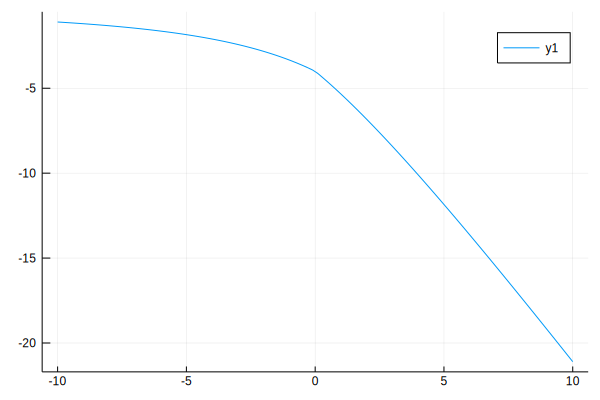

In [92]:
nsite = 4
nelec = nsite

nU = 100
Us = range(-10,length=nU,stop=10)
μs = Us/2
es = zeros(Float64,nU)
for i=1:nU
    hamiltonian = make_hamiltonian(μs[i],Us[i],nsite)
    hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)
    e,v = eigen(hamiltonian)
    es[i] = e[1]
    println(Us[i],"\t",es[i])
end
using Plots
fig = plot(Us,es)
savefig(fig,"Fig1.png")
fig

エネルギーはUが増えるにつれてどんどん下がっていきます。これはなぜでしょうか？
この理由は、Uが非常に強い場合には、アップスピンとダウンスピンが同じ場所にあると強いクーロン斥力が生じるので、全ての電子はサイトに一つずつ入っているためです。サイトに一つ入ると化学ポテンシャルU/2の分だけエネルギーが下がります。今、粒子が4つあるので、全体で2Uです。ですので、U=10近傍では、E=-2Uとなっています。

次に、化学ポテンシャルは電子数を調整するために導入したものだったので、これを除いてみましょう。化学ポテンシャルの項を取り除き、電子数が4となっている状態だけを取り出し、対角化してエネルギー依存性を見たものが下です。

-10.0	-21.099877772749746
-9.797979797979798	-20.714957515128287
-9.595959595959595	-20.330660224926454
-9.393939393939394	-19.947014215323872
-9.191919191919192	-19.564049369892494
-8.98989898989899	-19.181797239209015
-8.787878787878787	-18.800291143381415
-8.585858585858587	-18.419566280774134
-8.383838383838384	-18.039659843214878
-8.181818181818182	-17.660611137961357
-7.97979797979798	-17.282461716698084
-7.777777777777778	-16.90525551182342
-7.575757575757576	-16.529038980272027
-7.373737373737374	-16.15386125510201
-7.171717171717172	-15.779774305057161
-6.96969696969697	-15.406833102295419
-6.767676767676767	-15.035095798456222
-6.565656565656566	-14.664623909227164
-6.363636363636363	-14.295482507563568
-6.161616161616162	-13.927740425725869
-5.959595959595959	-13.561470466331292
-5.757575757575758	-13.19674962268264
-5.555555555555555	-12.833659308749711
-5.353535353535354	-12.472285599358635
-5.151515151515151	-12.112719481410426
-4.94949494949495	-11.755057117333353
-4.747

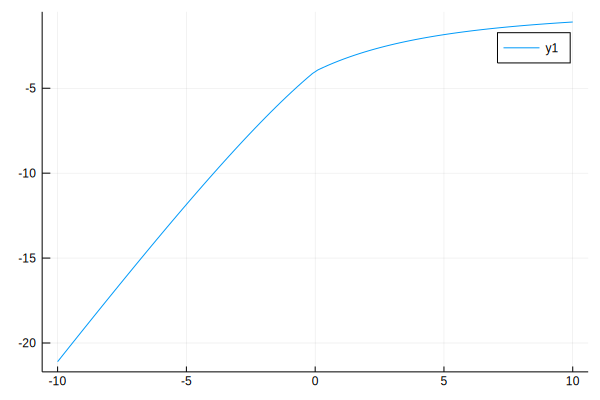

In [93]:
nsite = 4
nelec = nsite

nU = 100
Us = range(-10,length=nU,stop=10)
μs = Us *0
es = zeros(Float64,nU)
for i=1:nU
    hamiltonian = make_hamiltonian(μs[i],Us[i],nsite)
    hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)
    e,v = eigen(hamiltonian)
    es[i] = e[1]
    println(Us[i],"\t",es[i])
end
fig = plot(Us,es)
savefig(fig,"Fig2.png")
fig

今度は、Uが大きい時に定数のような振る舞いをしています。これは、強い斥力相互作用で電子が一つずつ入っているということにより、Uの効果が消えたためです。今回は化学ポテンシャルの項がないので、一つのサイトに一つ入っている時にエネルギーの変化はありません。

次に、電子数が保存している状態で、第一励起状態と基底状態のエネルギーの差をそれぞれで計算してみましょう。

-10.0	0.3042232858772209
-9.797979797979798	0.30728227642974915
-9.595959595959595	0.3103218602784352
-9.393939393939394	0.31333287287956324
-9.191919191919192	0.31630495826007987
-8.98989898989899	0.3192264351449374
-8.787878787878787	0.32208415015252
-8.585858585858587	0.3248633174355149
-8.383838383838384	0.32754734433313004
-8.181818181818182	0.3301176428893555
-7.97979797979798	0.3325534275016224
-7.777777777777778	0.33483149953276126
-7.575757575757576	0.3369260204895106
-7.373737373737374	0.3388082763946869
-7.171717171717172	0.3404464373126004
-6.96969696969697	0.3418053177015814
-6.767676767676767	0.34284614542961833
-6.565656565656566	0.3435263499780845
-6.363636363636363	0.3437993836377746
-6.161616161616162	0.34361459342627576
-5.959595959595959	0.34291716603897626
-5.757575757575758	0.34164817334684905
-5.555555555555555	0.33974475164212414
-5.353535353535354	0.33714045374652635
-5.151515151515151	0.333765818804709
-4.94949494949495	0.3295492094417778
-4.747474747474747	0.

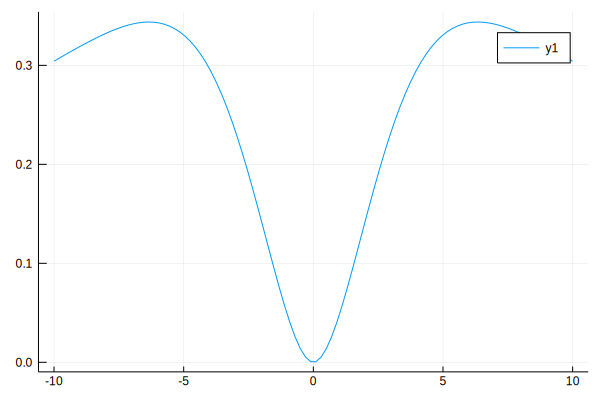

In [94]:
nsite = 4
nelec = nsite

nU = 100
Us = range(-10,length=nU,stop=10)
μs = Us/2
es = zeros(Float64,nU)
for i=1:nU
    hamiltonian = make_hamiltonian(μs[i],Us[i],nsite)
    hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)
    e,v = eigen(hamiltonian)
    es[i] = e[2]-e[1]
    println(Us[i],"\t",es[i])
end
using Plots
fig = plot(Us,es)
savefig(fig,"Fig3.png")
fig

-10.0	0.30422328587724223
-9.797979797979798	0.30728227642971007
-9.595959595959595	0.31032186027844233
-9.393939393939394	0.3133328728795739
-9.191919191919192	0.31630495826013316
-8.98989898989899	0.319226435144941
-8.787878787878787	0.3220841501525271
-8.585858585858587	0.3248633174355149
-8.383838383838384	0.32754734433313004
-8.181818181818182	0.3301176428893555
-7.97979797979798	0.332553427501626
-7.777777777777778	0.3348314995327222
-7.575757575757576	0.33692602048949283
-7.373737373737374	0.3388082763946958
-7.171717171717172	0.34044643731260393
-6.96969696969697	0.3418053177015672
-6.767676767676767	0.3428461454296041
-6.565656565656566	0.34352634997809517
-6.363636363636363	0.3437993836377764
-6.161616161616162	0.34361459342627043
-5.959595959595959	0.3429171660389514
-5.757575757575758	0.34164817334682596
-5.555555555555555	0.33974475164213835
-5.353535353535354	0.3371404537465299
-5.151515151515151	0.33376581880468237
-4.94949494949495	0.3295492094417405
-4.747474747474747	

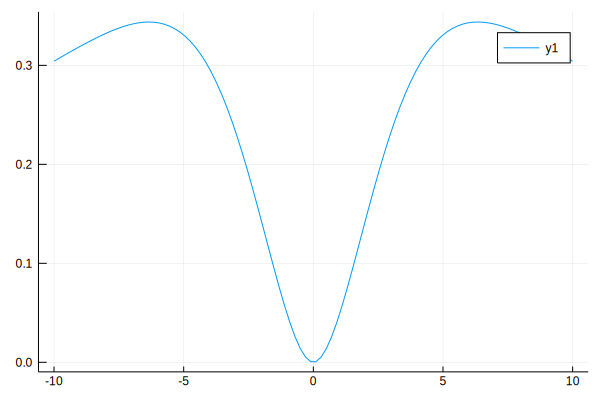

In [95]:
nsite = 4
nelec = nsite

nU = 100
Us = range(-10,length=nU,stop=10)
μs = Us *0
es = zeros(Float64,nU)
for i=1:nU
    hamiltonian = make_hamiltonian(μs[i],Us[i],nsite)
    hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)
    e,v = eigen(hamiltonian)
    es[i] = e[2]-e[1]
    println(Us[i],"\t",es[i])
end
using Plots
fig = plot(Us,es)
savefig(fig,"Fig4.png")
fig

どちらで計算しても、結果は同じになっています。これは、1枚目が全エネルギーの測り方基準値がUに依存していただけで物理としてはどちらも変わらないことを意味しています。

最後に、電子数が保存している系の全てのエネルギー固有値をプロットしてみましょう。

-10.0	0.30422328587724223
-9.797979797979798	0.30728227642971007
-9.595959595959595	0.31032186027844233
-9.393939393939394	0.3133328728795739
-9.191919191919192	0.31630495826013316
-8.98989898989899	0.319226435144941
-8.787878787878787	0.3220841501525271
-8.585858585858587	0.3248633174355149
-8.383838383838384	0.32754734433313004
-8.181818181818182	0.3301176428893555
-7.97979797979798	0.332553427501626
-7.777777777777778	0.3348314995327222
-7.575757575757576	0.33692602048949283
-7.373737373737374	0.3388082763946958
-7.171717171717172	0.34044643731260393
-6.96969696969697	0.3418053177015672
-6.767676767676767	0.3428461454296041
-6.565656565656566	0.34352634997809517
-6.363636363636363	0.3437993836377764
-6.161616161616162	0.34361459342627043
-5.959595959595959	0.3429171660389514
-5.757575757575758	0.34164817334682596
-5.555555555555555	0.33974475164213835
-5.353535353535354	0.3371404537465299
-5.151515151515151	0.33376581880468237
-4.94949494949495	0.3295492094417405
-4.747474747474747	

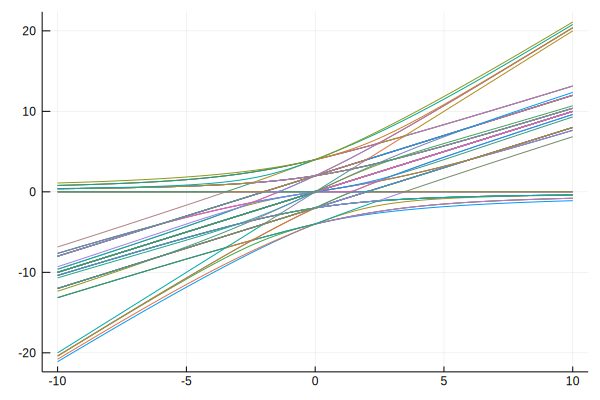

In [97]:
nsite = 4
nelec = nsite

nU = 100
Us = range(-10,length=nU,stop=10)
μs = Us *0
es = zeros(Float64,nU)
es2 = zeros(Float64,nU,70)
for i=1:nU
    hamiltonian = make_hamiltonian(μs[i],Us[i],nsite)
    hamiltonian =reduce_hamiltonian(hamiltonian,nsite,nelec)
    e,v = eigen(hamiltonian)
    es[i] = e[2]-e[1]
    es2[i,:] = e[:]
#    push!(es2,e)
    println(Us[i],"\t",es[i])
end
using Plots
fig = plot(Us,es2,labels="")
savefig(fig,"Fig5.png")
fig

綺麗な絵が出ました。この計算では化学ポテンシャルは除いています。Uが大きい時には、Uに比例するエネルギー状態と、0に近く状態があるのがわかります。完全にエネルギーがゼロの状態がありますが、これは、電子が全て同じスピンを持っている状態です。ハーフフィリングを考えているので、4つのアップスピンがあるような状態です。この状態では、ホッピングもできず、tがなく、電子が1つずつなのでUもなく、結果、ゼロになっています。